In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, randint, uniform

OUT_DIR = "rf_daily_results_lag/"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "plots"), exist_ok=True)

DATE_COL = "Date"
TARGET = "N2O_Flux_ln"
RANDOM_STATE = 42
N_ITER = 100


In [2]:
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024.csv")
oensingen_daily_2 = pd.read_csv("../datasets/Oensingen_Daily_2021-23_clean.csv")

datasets = {
    "Chamau Daily": chamau_daily,
    "Oensingen Daily 2": oensingen_daily_2
}

for name, df in datasets.items():
    print(name, df.shape)


Chamau Daily (2908, 73)
Oensingen Daily 2 (374, 79)


In [4]:
predictors = [
    # Current
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_4cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # Lagged vars
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",

    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",

    "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",

    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

    # Management & temporal
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation",
    "month", "day", "hour"
]

# Filter predictors per dataset later, depending on availability


In [5]:
def split_train_val_test(df, predictors, target, date_col):
    df = df.dropna(subset=predictors + [target]).sort_values(date_col)
    n = len(df)
    n_test, n_val = int(n * 0.15), int(n * 0.15)
    train = df.iloc[: n - n_val - n_test]
    val   = df.iloc[n - n_val - n_test : n - n_test]
    test  = df.iloc[n - n_test :]
    return train, val, test

def make_pipeline(use_pca):
    steps = []
    if use_pca:
        steps.append(("pca", PCA(n_components=0.95)))
    steps.append(("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)))
    return Pipeline(steps)


In [16]:
param_dist = {
    # Focus around 500–900 but allow slight extension
    "rf__n_estimators": randint(450, 900),
    
    # Allow ± 10 variation around observed best depths
    "rf__max_depth": [None] + list(range(20, 60)),
    
    # Focus across leaf sizes near 3–10
    "rf__min_samples_leaf": randint(3, 10),

    # Focus across splits near 3–12
    "rf__min_samples_split": randint(3, 12),

    # Restricted *but varied* search around observed preferences
    "rf__max_features": [
        "sqrt", "log2",                      # keep discrete choices
        0.25, 0.30, 0.35, 0.40, 0.45          # fine resolution around 0.3
    ],
}

In [19]:
results = []

for name, df in datasets.items():
    print(f"\n=== Training on {name} ===")

    available = [p for p in predictors if p in df.columns]
    print(f"{len(available)} predictors available")

    if len(available) < 10:
        print("Skipping due to insufficient predictors")
        continue

    train, val, test = split_train_val_test(df, available, TARGET, DATE_COL)

    X_train = train[available].values
    y_train = train[TARGET].values
    X_val = val[available].values
    y_val = val[TARGET].values
    X_test = test[available].values
    y_test = test[TARGET].values

    X_tune = np.vstack([X_train, X_val])
    y_tune = np.concatenate([y_train, y_val])

    use_pca = len(available) > 100
    model = make_pipeline(use_pca)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=N_ITER,
        scoring="r2",
        n_jobs=-1,
        cv=3,
        random_state=RANDOM_STATE,
        verbose=1
    )

    search.fit(X_tune, y_tune)
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)

    print(f"Result: R²={r2:.3f}, r={r:.3f}")

    results.append({
        "Dataset": name,
        "R²": round(r2, 3),
        "Pearson_r": round(r, 3),
        "n_predictors": len(available),
        "use_pca": use_pca,
        "best_params": search.best_params_
    })

summary = pd.DataFrame(results)
summary



=== Training on Chamau Daily ===
66 predictors available
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Result: R²=0.295, r=0.581

=== Training on Oensingen Daily 2 ===
74 predictors available
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Result: R²=0.289, r=0.588


,Dataset,R²,Pearson_r,n_predictors,use_pca,best_params
0,Chamau Daily,0.295,0.581,66,False,"{'rf__max_depth': 59, 'rf__max_features': 0.3,..."
1,Oensingen Daily 2,0.289,0.588,74,False,"{'rf__max_depth': 29, 'rf__max_features': 'log..."


In [18]:
summary.to_csv(os.path.join(OUT_DIR, "rf_daily_lag_summary.csv"), index=False)
summary

,Dataset,R²,Pearson_r,n_predictors,use_pca,best_params
0,Chamau Daily,0.295,0.577,66,False,"{'rf__max_depth': 28, 'rf__max_features': 0.3,..."
1,Oensingen Daily 2,0.306,0.602,74,False,"{'rf__max_depth': 38, 'rf__max_features': 'log..."


In [15]:
print(summary["best_params"][0])
print(summary["best_params"][1])

{'rf__max_depth': 28, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 6, 'rf__n_estimators': 643}
{'rf__max_depth': 38, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 5, 'rf__n_estimators': 569}


In [20]:
best_params_chamau = {
    'rf__n_estimators': 643,
    'rf__max_depth': 28,
    'rf__min_samples_split': 6,
    'rf__min_samples_leaf': 6,
    'rf__max_features': 0.3
}

best_params_oensingen = {
    'rf__n_estimators': 569,
    'rf__max_depth': 38,
    'rf__min_samples_split': 5,
    'rf__min_samples_leaf': 6,
    'rf__max_features': 'log2'
}


Chamau Daily: R²=0.336, r=0.623, OOB=0.384


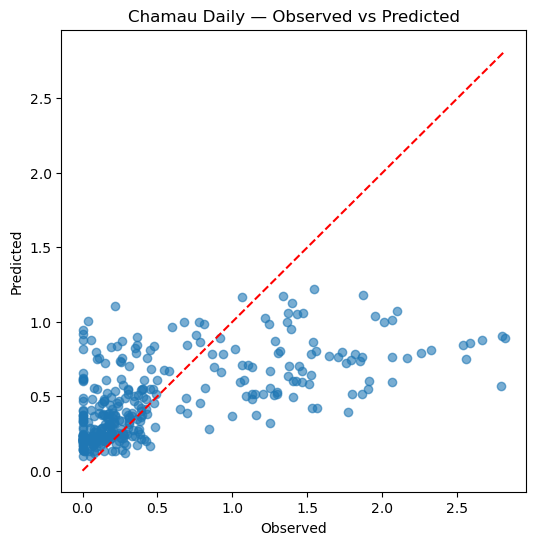

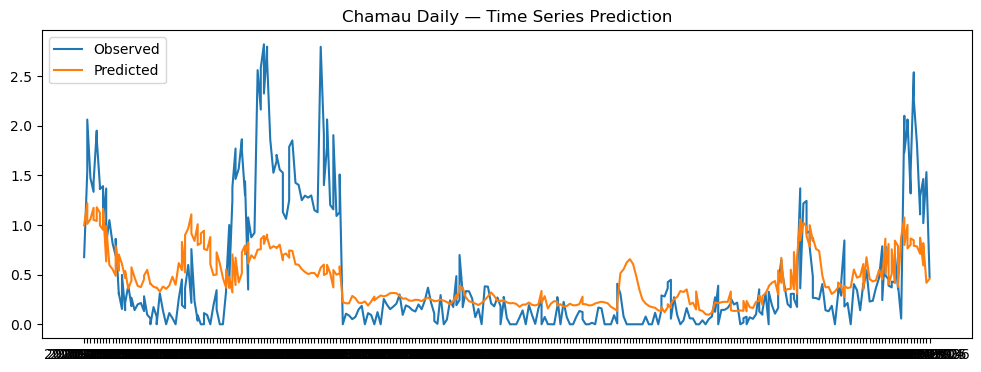

Oensingen Daily 2: R²=0.278, r=0.573, OOB=0.379


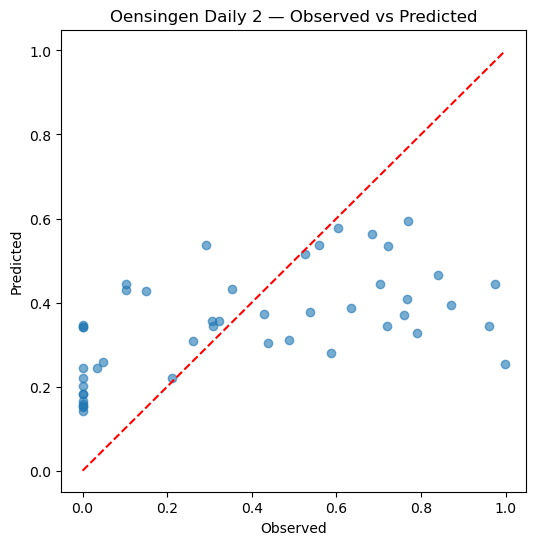

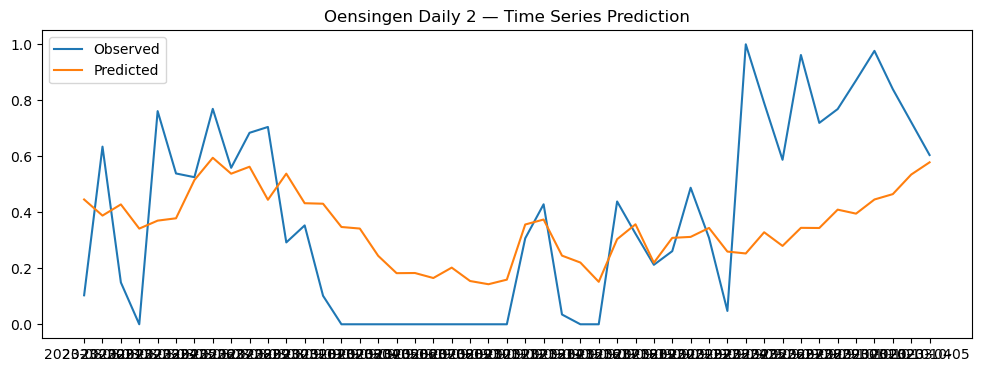

In [26]:
def train_and_plot(name, df, params):
    available = [p for p in predictors if p in df.columns]
    df = df.dropna(subset=available + [TARGET]).sort_values(DATE_COL)
    
    n = len(df)
    n_test, n_val = int(n*0.15), int(n*0.15)
    train = df.iloc[:n - n_val - n_test]
    test  = df.iloc[n - n_test:]
    
    X_train = train[available]
    y_train = train[TARGET]
    X_test = test[available]
    y_test = test[TARGET]
    
    model = RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True,
        **{k.replace("rf__", ""): v for k,v in params.items()}
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    r,_ = pearsonr(y_test, y_pred)
    
    print(f"{name}: R²={r2:.3f}, r={r:.3f}, OOB={model.oob_score_:.3f}")
    
    # Scatter
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, 'r--')
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(f"{name} — Observed vs Predicted")
    plt.show()

    # Time series
    plt.figure(figsize=(12,4))
    plt.plot(test[DATE_COL], y_test, label="Observed")
    plt.plot(test[DATE_COL], y_pred, label="Predicted")
    plt.legend()
    plt.title(f"{name} — Time Series Prediction")
    plt.show()


train_and_plot("Chamau Daily", chamau_daily, best_params_chamau)
train_and_plot("Oensingen Daily 2", oensingen_daily_2, best_params_oensingen)


In [31]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

search_space = {
    "n_estimators": Integer(450, 900),
    "max_depth": Integer(15, 60),
    "min_samples_split": Integer(3, 12),
    "min_samples_leaf": Integer(3, 10),
    "max_features": Categorical([0.25, 0.30, 0.35, "sqrt", "log2"])
}

def bayes_optimize(df, name):
    available = [p for p in predictors if p in df.columns]
    df = df.dropna(subset=available + [TARGET]).sort_values(DATE_COL)

    n = len(df)
    n_test, n_val = int(n*0.15), int(n*0.15)
    train = df.iloc[:n - n_val - n_test]
    test  = df.iloc[n - n_test:]

    X_train = train[available]
    y_train = train[TARGET]
    X_test = test[available]
    y_test = test[TARGET]

    opt = BayesSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True, oob_score=True),
        search_space,
        n_iter=40,             
        scoring="r2",
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    opt.fit(X_train, y_train)
    best = opt.best_estimator_

    y_pred = best.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r,_ = pearsonr(y_test, y_pred)

    print(f"\n{name} — Bayesian Optimization Best Params:")
    print(opt.best_params_)
    print(f"R²={r2:.3f}, r={r:.3f}, OOB={best.oob_score_:.3f}")

    return best


In [32]:
best_chamau = bayes_optimize(chamau_daily, "Chamau Daily")
best_oensingen = bayes_optimize(oensingen_daily_2, "Oensingen Daily 2")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
# Chamau Daily — Bayesian Optimization Best Params:
# OrderedDict([('max_depth', 20), ('max_features', 0.35), ('min_samples_leaf', 8), ('min_samples_split', 3), ('n_estimators', 460)])
# R²=0.330, r=0.612, OOB=0.375

# Oensingen Daily 2 — Bayesian Optimization Best Params:
# OrderedDict([('max_depth', 38), ('max_features', 0.35), ('min_samples_leaf', 9), ('min_samples_split', 11), ('n_estimators', 897)])
# R²=0.256, r=0.511, OOB=0.306